In [43]:
from dotenv import  load_dotenv
from langchain_openai import ChatOpenAI

load_dotenv()

llm = ChatOpenAI(model='gpt-4o')
small_llm = ChatOpenAI(model='gpt-4o-mini')

In [44]:
from langchain_community.tools import DuckDuckGoSearchRun

search_tool = DuckDuckGoSearchRun() 

In [45]:
from langchain_google_community import GmailToolkit
from langchain_google_community.gmail.utils import (build_resource_service, get_gmail_credentials)

credentials = get_gmail_credentials(
    token_file="./google/token.json",
    scopes=["https://mail.google.com/"],
    client_secrets_file="./google/gmail_credentials.json"
)

api_resource = build_resource_service(credentials=credentials)

gmail_toolkit = GmailToolkit(api_resource=api_resource)

gmail_tool_list = gmail_toolkit.get_tools()

gmail_tool_list

[GmailCreateDraft(api_resource=<googleapiclient.discovery.Resource object at 0x177b53a50>),
 GmailSendMessage(api_resource=<googleapiclient.discovery.Resource object at 0x177b53a50>),
 GmailSearch(api_resource=<googleapiclient.discovery.Resource object at 0x177b53a50>),
 GmailGetMessage(api_resource=<googleapiclient.discovery.Resource object at 0x177b53a50>),
 GmailGetThread(api_resource=<googleapiclient.discovery.Resource object at 0x177b53a50>)]

In [46]:
from langchain_classic.agents import load_tools

loaded_tool_list = load_tools(
    ["arxiv"]
)

loaded_tool_list

[ArxivQueryRun(api_wrapper=ArxivAPIWrapper(arxiv_search=<class 'arxiv.Search'>, arxiv_exceptions=(<class 'arxiv.ArxivError'>, <class 'arxiv.UnexpectedEmptyPageError'>, <class 'arxiv.HTTPError'>), top_k_results=3, ARXIV_MAX_QUERY_LENGTH=300, continue_on_failure=False, load_max_docs=100, load_all_available_meta=False, doc_content_chars_max=4000))]

In [47]:
from langchain_chroma import Chroma
from langchain_openai import OpenAIEmbeddings
from langchain_core.tools.retriever import create_retriever_tool


embeddings = OpenAIEmbeddings(model='text-embedding-3-large')

vector_store = Chroma(
    embedding_function = embeddings,
    collection_name = 'real_estate_tax2',
    persist_directory = './real_estate_tax_collection2'
)
retriever = vector_store.as_retriever(search_kwargs={'k':3})


retriever_tool = create_retriever_tool(
    retriever=retriever,
    name='real_estate_tax_retreiver',
    description='Contains information about real estate tax up to December 2025'
)

In [48]:
from langgraph.prebuilt import ToolNode

tool_list = [ search_tool, retriever_tool] + gmail_tool_list + loaded_tool_list

llm_with_tools = llm.bind_tools(tool_list)  

tool_node = ToolNode(tool_list) 


In [78]:
from langgraph.graph import MessagesState, StateGraph

class AgentState(MessagesState):
    summary: str

graph_builder = StateGraph(AgentState)

In [79]:
from langchain_core.messages import SystemMessage

def agent(state: AgentState):
    messages = state['messages']
    summary = state['summary']
    
    if summary != '':
        messages = [SystemMessage(content=f'Here is the sumary of the earlier conversation: {summary}')] + messages
    
    response = llm_with_tools.invoke(messages)
    
    print(f'message length == {len(messages)}')
    return {'messages': [response]}

In [80]:
from langgraph.types import interrupt, Command
from typing import Literal

def huaman_review(state: AgentState) -> Command[Literal['tools', 'agent']]:
    messages = state['messages']
    last_message = messages[-1]
    tool_call = last_message.tool_calls[-1]
    
    human_review = interrupt({ # 
        'qeustion': '이렇게 진행하면 될까요?',
        'tool_call': tool_call
    })
    
    review_action = human_review['action']
    review_data = human_review.get('data', None)
    
    
    if review_action == 'continue':
        return Command(goto='tools')
    

    if review_action == 'update_args':
        updated_ai_message = {
            'id': last_message.id,
            'role': 'ai',
            'content': last_message.content,
            'tool_calls': [{
                'id': tool_call['id'],
                'name': tool_call['name'],
                'args': review_data
            }],
        }
        return Command(goto='tools', update={'messages': [updated_ai_message]})
    
    
    
    if review_action == 'update_tool':
        updated_tool_message = {
            'tool_call_id': tool_call['id'],
            'name': tool_call['name'],
            'role': 'tool',
            'content': review_data
        }
        return Command(goto='agent', update={'messages': [updated_tool_message]})
    

In [81]:
def summarize_messages(state: AgentState):
    messages = state['messages']
    summary = state['summary']
    
    summary_prompt = f'summarize this chat history below: \n\n chat history: {messages}'
    
    if summary != '':
        summary_prompt = f'''summarize this chat history below while looking at the summary of earlier conversations
                            chat_history: {messages}
                            summary: {summary}'''
        
    summary = small_llm.invoke(summary_prompt)
    response = llm_with_tools.invoke(messages)
    return {'summary': response.content}

In [82]:
from langchain_core.messages import RemoveMessage
    
def delete_messages(state: AgentState):
    messages = state['messages'] 
    left_messages = [RemoveMessage(id=message.id) for message in messages[:-3]] 
    return {'messages': left_messages}

In [83]:
def should_continue(state: AgentState):
    messages = state['messages']
    last_ai_message = messages[-1]
    
    if last_ai_message.tool_calls:
        return 'huaman_review'
    return 'summarize_messages'

In [84]:
graph_builder.add_node('tools', tool_node)
graph_builder.add_node(agent)
graph_builder.add_node(delete_messages)
graph_builder.add_node(huaman_review)
graph_builder.add_node(summarize_messages)

In [85]:
from langgraph.graph import START, END

graph_builder.add_edge(START, 'agent')

graph_builder.add_conditional_edges(
    'agent',
    should_continue,
    ['huaman_review', 'summarize_messages']
)

graph_builder.add_edge('tools', 'agent')
graph_builder.add_edge('summarize_messages', 'delete_messages')
graph_builder.add_edge('delete_messages', END)

In [86]:
from langgraph.checkpoint.memory import MemorySaver

checkpointer = MemorySaver() 

graph = graph_builder.compile(checkpointer=checkpointer) 

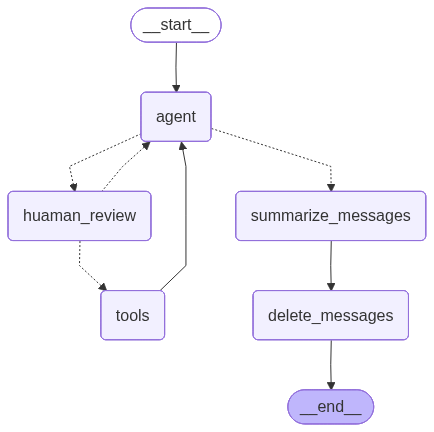

In [87]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [88]:
from langchain_core.messages import HumanMessage

config = {
    'configurable': {
        'thread_id': 'paper_summary'
    }
}

query='please Summarize the LLM Survey paper and Write a draft to ksz18601@gmail.com'

for chunk in graph.stream({'messages': [HumanMessage(query)], 'summary':''}, stream_mode='values', config=config): # 
    chunk['messages'][-1].pretty_print()

================================ Human Message =================================

please Summarize the LLM Survey paper and Write a draft to ksz18601@gmail.com
message length == 1
================================== Ai Message ==================================
Tool Calls:
  arxiv (call_Nfpq30Eejj5ylW6FuQiIJFFB)
 Call ID: call_Nfpq30Eejj5ylW6FuQiIJFFB
  Args:
    query: LLM Survey


In [89]:
graph.get_state(config).values['messages']

[HumanMessage(content='please Summarize the LLM Survey paper and Write a draft to ksz18601@gmail.com', additional_kwargs={}, response_metadata={}, id='795273e0-8950-472c-ad2d-772253b2c866'),
 AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_Nfpq30Eejj5ylW6FuQiIJFFB', 'function': {'arguments': '{"query":"LLM Survey"}', 'name': 'arxiv'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 16, 'prompt_tokens': 711, 'total_tokens': 727, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_deacdd5f6f', 'finish_reason': 'tool_calls', 'logprobs': None}, id='lc_run--019b3f18-5b1f-73d0-8399-386abc3fd33a-0', tool_calls=[{'name': 'arxiv', 'args': {'query': 'LLM Survey'}, 'id': 'call_Nfpq30Eejj5ylW6FuQiIJFFB', 'type': 'tool_

In [74]:
for chunk in graph.stream(
    Command(resume={'action': 'continue'}),
    config=config,
    stream_mode='updates'
): print(chunk)

{'huaman_review': None}
{'tools': {'messages': [ToolMessage(content='2025. 1. 3. · This survey paper explores the foundational components, scaling mechanisms, and architectural strategies that drive these capabilities. 2025. 3. 23. · In this paper, we review some of the most prominent LLMs, including three popular LLM families (GPT, LLaMA, PaLM), and discuss their characteristics, ... 2025. 3. 11. · A collection of papers and resources related to Large Language Models. The organization of papers refers to our survey "A Survey of Large Language Models". 2025. 3. 16. · 대형 언어 모델(LLM)은 다양한 작업에서 뛰어난 성능을 보이지만, 실제 성능을 평가하려면 여러 평가 지표와 데이터셋이 필요함. 이 섹션에서는 LLM 성능을 평가하기 위해 ... 2025. 6. 7. · This article surveys the relationship between LLMs and knowledge bases, looks at how they can be applied in practice, and discusses related technical, ...', name='duckduckgo_search', id='a660f018-7788-45cf-b365-6e8513bbffe8', tool_call_id='call_zr3VhB88SivmZm5TQWBnaXx2')]}}
message length == 5
{'agent': {'messa

In [90]:
for chunk in graph.stream(
    Command(resume={'action': 'update_args',
                    'data': {'query': 'Large Language Model: A Survey'}}),
    config=config,
    stream_mode='updates'
): print(chunk)

{'huaman_review': {'messages': [{'id': 'lc_run--019b3f18-5b1f-73d0-8399-386abc3fd33a-0', 'role': 'ai', 'content': '', 'tool_calls': [{'id': 'call_Nfpq30Eejj5ylW6FuQiIJFFB', 'name': 'arxiv', 'args': {'query': 'Large Language Model: A Survey'}}]}]}}
{'tools': {'messages': [ToolMessage(content="Published: 2015-08-17\nTitle: Observation of the rare $B^0_s\\toμ^+μ^-$ decay from the combined analysis of CMS and LHCb data\nAuthors: The CMS, LHCb Collaborations, :, V. Khachatryan, A. M. Sirunyan, A. Tumasyan, W. Adam, T. Bergauer, M. Dragicevic, J. Erö, M. Friedl, R. Frühwirth, V. M. Ghete, C. Hartl, N. Hörmann, J. Hrubec, M. Jeitler, W. Kiesenhofer, V. Knünz, M. Krammer, I. Krätschmer, D. Liko, I. Mikulec, D. Rabady, B. Rahbaran, H. Rohringer, R. Schöfbeck, J. Strauss, W. Treberer-Treberspurg, W. Waltenberger, C. -E. Wulz, V. Mossolov, N. Shumeiko, J. Suarez Gonzalez, S. Alderweireldt, S. Bansal, T. Cornelis, E. A. De Wolf, X. Janssen, A. Knutsson, J. Lauwers, S. Luyckx, S. Ochesanu, R. Rougn

In [71]:
for chunk in graph.stream(
    Command(resume={'action': 'update_tool',
                    'data': {'query': 'please search in the Web instead of arxiv'}}),
    config=config,
    stream_mode='updates'
): print(chunk)

{'huaman_review': {'messages': [{'tool_call_id': 'call_ib5mmc1FWMggKubv4R6SCmzv', 'name': 'arxiv', 'role': 'tool', 'content': {'query': 'please search in the Web instead of arxiv'}}]}}
message length == 3
{'agent': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_zr3VhB88SivmZm5TQWBnaXx2', 'function': {'arguments': '{"query":"LLM Survey paper"}', 'name': 'duckduckgo_search'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 20, 'prompt_tokens': 749, 'total_tokens': 769, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_deacdd5f6f', 'finish_reason': 'tool_calls', 'logprobs': None}, id='lc_run--019b3f0a-e7f9-7680-9cec-3da3193324eb-0', tool_calls=[{'name': 'duckduckgo_search', 'args': {'query': '